## Example use: climate extreme events

Author: Laura Muntjewerf, 2022

Aim of the case study: show the advantage of large ensemble modelling for extreme climatologies.

In [1]:
import os
import sys
libdir = os.path.dirname('/usr/people/muntjewe/git/laura_scripts/')
sys.path.insert(0, libdir) 


from libpyvarex import libplot
from libpyvarex import libtimeseries

In [2]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# Name some Cartopy projections for ease of use\n",
myproj = ccrs.PlateCarree()

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import cmocean.cm as cmo
from matplotlib import cm

In [4]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [5]:
import numpy as np
import xarray as xr

In [6]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Open the dataset

In [8]:
# voor 2e rij
ds_tas=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/Amon/tas/tas*.nc',combine='nested',concat_dim='ens')
tas=ds_tas['tas']
ds_tas2k=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/2K/Amon/tas/tas*.nc',combine='nested',concat_dim='ens')
tas2k=ds_tas2k['tas']

In [7]:
# voor 2e rij
ds_pr=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/Amon/pr/pr*.nc',combine='nested',concat_dim='ens')
pr=ds_pr['pr']
ds_pr2k=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/2K/Amon/pr/pr*.nc',combine='nested',concat_dim='ens')
pr2k=ds_pr2k['pr']

In [9]:
# voor 2e rij
ds_mrso=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/Lmon/mrso/mrso*.nc',combine='nested',concat_dim='ens')
mrso=ds_mrso['mrso']
ds_mrso2k=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/2K/Lmon/mrso/mrso*.nc',combine='nested',concat_dim='ens')
mrso2k=ds_mrso2k['mrso']

In [10]:
# voor 2e rij
ds_snm=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/LImon/snm/snm*.nc',combine='nested',concat_dim='ens')
snm=ds_snm['snm']
ds_snm2k=xr.open_mfdataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/2K/LImon/snm/snm*.nc',combine='nested',concat_dim='ens')
snm2k=ds_snm2k['snm']



### Do a bunch of calculations

#### two PDFs of ANN GMST 

In [2]:
ANN_GMST_PD = []
ANN_GMST_2K = []

for time in 'PD','2K':
    for i in np.arange(1,16+1):
        for j in np.arange(0,9+1):
            # open the dataset
            print('working on: '+time+str(i).zfill(2)+str(j))
            if time == 'PD':
                ds=xr.open_dataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/PD/Amon/tas/tas_h'+str(i).zfill(2)+str(j)+'.nc')
                annual_global_mean = libtimeseries.boxmean(ds['tas']).groupby('time.year').mean('time')
                ANN_GMST_PD.append(annual_global_mean)
            elif time == '2K':
                ds=xr.open_dataset('/usr/people/muntjewe/nobackup/nobackup_1/LENTIS/2K/Amon/tas/tas_s'+str(i).zfill(2)+str(j)+'.nc')
                annual_global_mean = libtimeseries.boxmean(ds['tas']).groupby('time.year').mean('time')
                ANN_GMST_2K.append(annual_global_mean)
            else:
                'error, something wrong'
            ds.close()

### Greenland snow melt 

In [3]:
lat=61.2
lon=-42
snmGRN=snm.sel(lat=lat,lon=lon,method='nearest').groupby('time.month')
snmGRN7 = snmGRN[7]
snm2kGRN=snm2k.sel(lat=lat,lon=lon,method='nearest').groupby('time.month')
snm2kGRN7 = snm2kGRN[7]
snmGRN7_day = snmGRN7*24*60*60
snm2kGRN7_day = snm2kGRN7*24*60*60

In [11]:
# draw extreme values from observations(empirical distribution)
N    = np.r_[1:len(snmGRN7_day.values.flatten())+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)


x1=Nmax/N
y1a=sorted(snmGRN7_day.values.flatten())[::-1]
y1b=sorted(snm2kGRN7_day.values.flatten())[::-1]

### England soil moisture 

In [4]:
lat=51
lon=-2
mrsoGRN=mrso.sel(lat=lat,lon=lon,method='nearest').groupby('time.month')
mrsoGRN7 = mrsoGRN[7]
mrso2kGRN=mrso2k.sel(lat=lat,lon=lon,method='nearest').groupby('time.month')
mrso2kGRN7 = mrso2kGRN[7]

In [13]:
x2a=mrsoGRN7.values.flatten()
meanx2a=np.mean(x2a)

x2b=mrso2kGRN7.values.flatten()
meanx2b=np.mean(x2b)



In [5]:
tasGRN=tas.sel(lat=lat,lon=lon,method='nearest').groupby('time.month')
tasGRN7 = tasGRN[7]
tas2kGRN=tas2k.sel(lat=lat,lon=lon,method='nearest').groupby('time.month')
tas2kGRN7 = tas2kGRN[7]

z2a=tasGRN7.values.flatten()
meanz2a=np.mean(z2a)

z2b=tas2kGRN7.values.flatten()
meanz2b=np.mean(z2b)

### horn of Africa precip

In [6]:
lat=8
lon=47.81
haPD=pr.sel(lat=lat,lon=lon,method='nearest').groupby('time.month').mean().unstack()*24*60*60
ha2K=pr2k.sel(lat=lat,lon=lon,method='nearest').groupby('time.month').mean().unstack()*24*60*60




## plot and save the figures

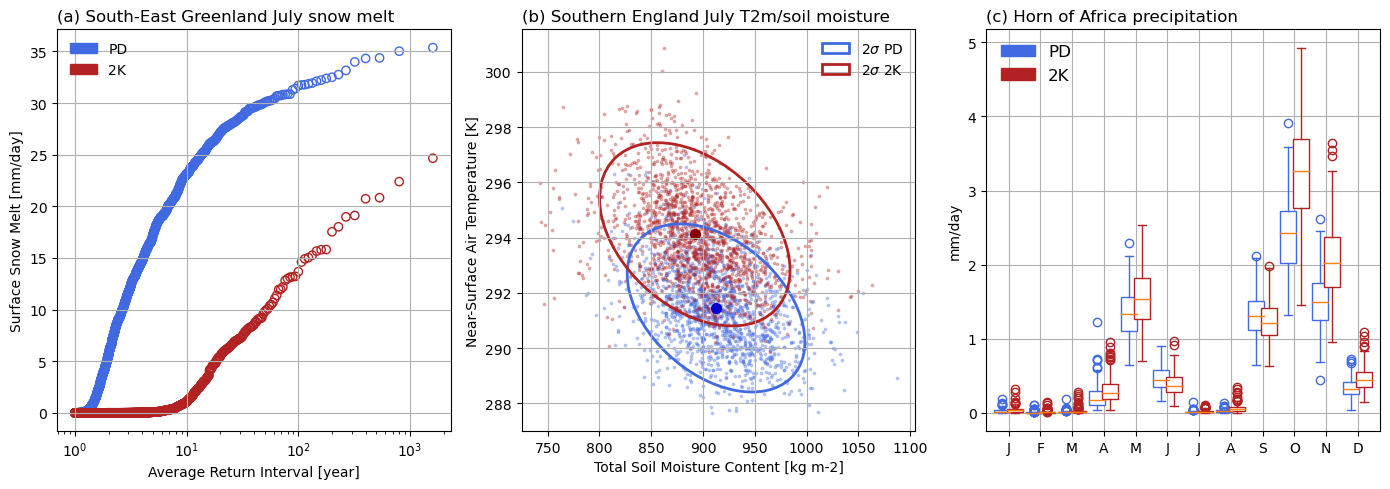

In [25]:


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5))

colour1 = 'royalblue'
colour2 = 'firebrick'

black_patch = mpatches.Patch(color=colour1, label='PD')
red_patch = mpatches.Patch(color=colour2, label='2K')  

# ======== fig 1

ax1.set_xscale('log')
ax1.set_xlabel('Average Return Interval [year]')
ax1.set_ylabel(snm.long_name+' [mm/day]')

ax1.scatter(x1, y1a, color=colour1, facecolors='none', label='PD')
ax1.scatter(x1, y1b, color=colour2, facecolors='none', label='2K')

ax1.legend(handles=[black_patch,red_patch], frameon=False)

ax1.set_title('(a) South-East Greenland July snow melt',loc='left',fontsize=12)
ax1.grid()


# ======== fig 2

ax2.scatter(x2a,z2a, alpha=0.3, color=colour1, s=3)
ax2.scatter(x2b,z2b, alpha=0.3, color=colour2, s=3)

confidence_ellipse(x2a,z2a, ax2, n_std=2,
                   label=r'$2\sigma$ PD', edgecolor=colour1,linewidth=2)
confidence_ellipse(x2b,z2b, ax2, n_std=2,
                   label=r'$2\sigma$ 2K', edgecolor=colour2,linewidth=2)

ax2.scatter(meanx2a, meanz2a, c='mediumblue', s=50)
ax2.scatter(meanx2b, meanz2b, c='darkred', s=50)

ax2.set_title('(b) Southern England July T2m/soil moisture',loc='left',fontsize=12)
ax2.set_ylabel(tas.long_name+' ['+tas.units+']')
ax2.set_xlabel(mrso.long_name+' ['+mrso.units+']')




ax2.legend(frameon=False)
ax2.grid()


# ======== fig 3


ax3.boxplot(haPD,positions=[0.3, 1.3, 2.3, 3.3, 4.3, 5.3, 6.3, 7.3, 8.3, 9.3, 10.3, 11.3 ],patch_artist=True, 
            boxprops=dict(facecolor='white', color=colour1),
            capprops=dict(color=colour1),
            whiskerprops=dict(color=colour1),
            flierprops=dict(color=colour1, markeredgecolor=colour1),manage_ticks=True)

ax3.boxplot(ha2K,positions=[0.7, 1.7, 2.7, 3.7, 4.7, 5.7, 6.7, 7.7, 8.7, 9.7, 10.7, 11.7],patch_artist=True, 
            boxprops=dict(facecolor='white', color=colour2),
            capprops=dict(color=colour2),
            whiskerprops=dict(color=colour2),
            flierprops=dict(color=colour2, markeredgecolor=colour2),manage_ticks=True)


ax3.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5 ], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D',])
ax3.set_ylabel('mm/day')

black_patch = mpatches.Patch(color=colour1, label='PD')   
red_patch = mpatches.Patch(color=colour2, label='2K') 
ax3.legend(frameon=False,fontsize=12,handles=[black_patch,red_patch])

ax3.set_title('(c) Horn of Africa precipitation ',loc='left',fontsize=12)
ax3.grid()



plt.tight_layout()

# plt.savefig(plotdir+"fig_datadescr_overview_rev.pdf")
plt.show()


